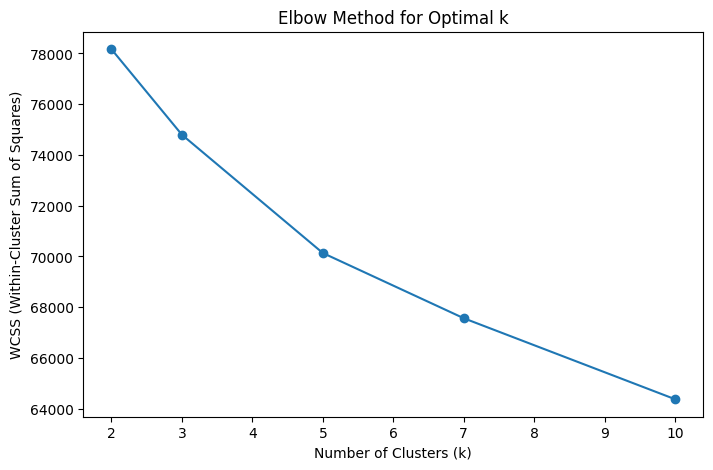

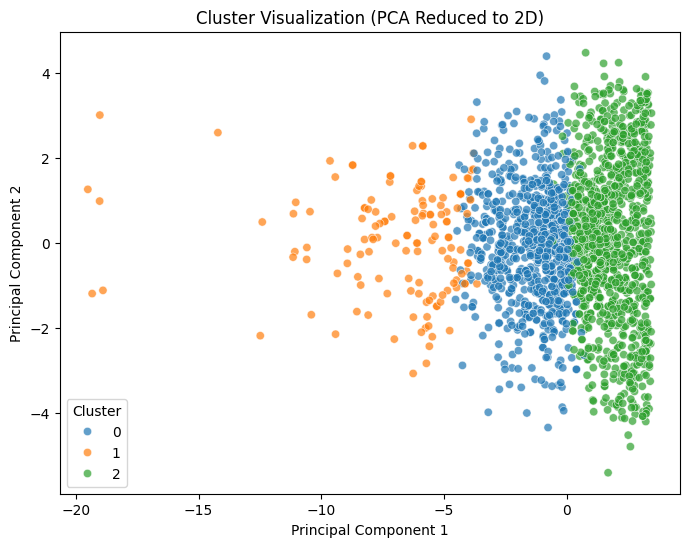

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer

# Load dataset
file_path = "D:/Downloads/ojt/dataset.csv"
df = pd.read_csv(file_path)

# Drop non-numeric columns
df_numeric = df.select_dtypes(include=[np.number])  # Keep only numeric columns

# Handle missing values using mean imputation
imputer = KNNImputer(n_neighbors=5)
df_numeric[:] = imputer.fit_transform(df_numeric)

# Standardize the dataset
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Apply PCA
pca = PCA(n_components=41)
pca_result = pca.fit_transform(df_scaled)

# Ensure row count consistency
assert pca_result.shape[0] == df_numeric.shape[0], "Row mismatch after PCA!"

# Determine optimal k using Elbow Method
wcss = []
k_values = [2, 3, 5, 7, 10]

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pca_result)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Apply K-Means with chosen k
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(pca_result)

# Assign clusters to df_numeric (same row count)
df_numeric["Cluster"] = clusters

# Reduce PCA to 2D for visualization
pca_visual = PCA(n_components=2)
pca_2d = pca_visual.fit_transform(df_scaled)

df_pca_2d = pd.DataFrame(pca_2d, columns=['PC1', 'PC2'])
df_pca_2d['Cluster'] = clusters

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca_2d, x='PC1', y='PC2', hue='Cluster', palette='tab10', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization (PCA Reduced to 2D)')
plt.legend(title='Cluster')
plt.show()

# Save the clustered dataset (only numeric columns + cluster labels)
df_numeric.to_csv("clustered_dataset.csv", index=False)


In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

# Load the dataset
file_path = "clustered_dataset.csv"
df = pd.read_csv(file_path)

# Select numerical columns
numerical_cols = df.select_dtypes(include=['float64']).columns
numerical_data = df[numerical_cols]

# Compute Z-scores
z_scores = np.abs(stats.zscore(numerical_data, nan_policy='omit'))

# Set threshold (commonly 3)
threshold = 3

# Identify outlier positions (True if outlier)
outlier_mask = z_scores > threshold

# Count the number of outliers per column and convert to Pandas Series for sorting
outlier_counts = pd.Series(outlier_mask.sum(axis=0), index=numerical_cols)

# Extract rows containing at least one outlier
outlier_rows = numerical_data[outlier_mask.any(axis=1)]

# Display outlier summary
print("Number of outliers per column:")
print(outlier_counts.sort_values(ascending=False))

print("\nRows containing outliers:")
print(outlier_rows)


Number of outliers per column:
I8.5:OTHERS       152
I7.5:OTHERS       129
J2:BOAT_TYPE       66
I3:???             39
J5.4               33
J6.2               33
J7.4               32
J6.1               31
J5.7               28
J5.5               26
J6.4               24
J7.2               22
J6.6               22
J6.3               20
J5.2               20
J6.5               19
J7.3               18
NY_W/BOAT           7
I6.4:H&L            3
I7.4:CP             1
I7.3:F_LIGHT        1
I6.2:FT             1
I6.3:PPN            1
B3:AGE              1
I8.1:BAD_W          1
J3:BOAT_DESIGN      1
J4:BOAT_COND        1
I8.2:FISH_R         1
J4: REASON-NO       1
I7.2:LIFE_B         0
I7.1:LIFE_J         0
I6.5:OTHERS         0
I6.1:GN             0
J5.1                0
BOAT_COND           0
J1:BOAT_AGREE       0
I8.3:BOAT_P         0
J5.3                0
J5.6                0
J7.1                0
J7.5                0
dtype: int64

Rows containing outliers:
      B3:AGE  I3:???  I6.1:

In [8]:
df_numeric["Cluster"].value_counts()

Cluster
2    1152
0     835
1     142
Name: count, dtype: int64

In [9]:
# Compute the mean of each variable per cluster
cluster_summary = df_numeric.groupby("Cluster").mean()
print(cluster_summary)


            B3:AGE    I3:???   I6.1:GN   I6.2:FT  I6.3:PPN  I6.4:H&L  \
Cluster                                                                
0        46.213566  1.084070  0.539560  0.094749  0.079188  0.706149   
1        47.633803  1.140845  0.464789  0.077465  0.112676  0.549296   
2        49.945312  1.288194  0.535590  0.135417  0.154514  0.592882   

         I6.5:OTHERS  I7.1:LIFE_J  I7.2:LIFE_B  I7.3:F_LIGHT  ...      J6.2  \
Cluster                                                       ...             
0           0.116302     0.298570     0.155865      0.840536  ...  3.856265   
1           0.084507     0.246479     0.105634      0.802817  ...  3.232394   
2           0.112847     0.318576     0.145833      0.857639  ...  4.536458   

             J6.3      J6.4      J6.5      J6.6      J7.1      J7.2      J7.3  \
Cluster                                                                         
0        4.254036  4.303640  4.271053  4.221163  2.983351  4.017407  4.077088   
